# MOT Challenge - Bus Video

https://motchallenge.net/vis/MOT16-13/det/

See the scripts: `bus-video-pred.py`, `bus-video-dets.py` and `bus-video-dets-ma3.py` in `../scripts/`.

Here I'm only showing the results of matching.

In [2]:
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import os

In [3]:
def get_highs(boxes, scores, threshold):
    ''' Returns only boxes with scores > threshold. '''

    highs = list(np.where(scores > threshold)[0])
    boxes_highs = []
    for high in highs:
        boxes_highs.append(list(boxes[high]))

    return boxes_highs

In [4]:
img_path = '/home/marko/data/video/bus-video/frames/'
img_names = list(sorted(os.listdir(img_path)))

img_path_pub = '/home/marko/data/video/bus-video/public-frames/'
img_names_pub = list(sorted(os.listdir(img_path_pub)))

dest_path = '/home/marko/data/video/bus-video/detected-frames/'

In [5]:
with open(r"../data/predictions-bus.pickle", "rb") as file:
    bus_preds = pickle.load(file)

In [125]:
threshold_dist = 5 # how close the bboxes have to be for matching

bus_preds_ma = {}
for i in range(3):
    img_name = img_names[i]
    bus_preds_ma[img_name] = bus_preds[img_name]['boxes']

for i in range(22, 30): # len(img_names)
    img_name = img_names[i]

    # j:
    # 'boxes': [bi, bi-1, bi-2],
    # 'scores': [si, si-1, si-2],
    # 'distances': [d(bi, bi-1), d(bi-1, bi-2)]
    ma = {}

    boxes = bus_preds[img_name]['boxes']
    scores = bus_preds[img_name]['scores']
#     boxes = get_highs(boxes, scores, 0.7)
    for j in range(len(boxes)):
        ma[j] = {'boxes': [], 'scores': [], 'distances': []}

    boxes1 = bus_preds[img_names[i-1]]['boxes']
    scores1 = bus_preds[img_names[i-1]]['scores']
#     boxes1 = get_highs(boxes1, scores1, 0.5)
    for j in range(len(boxes)):
        bj = np.array(boxes[j].copy())
        ma[j]['boxes'].append(boxes[j].copy())
        ma[j]['scores'].append(scores[j].copy())

        ## find nearest box to bj at previous frame
        mink = 0
        mind = 1e5
        for k in range(len(boxes1)):
            bk = np.array(boxes1[k].copy())
            dist = np.linalg.norm(bj[:2] - bk[:2]) # match only on x,y
            if dist < mind:
                mind = dist
                mink = k
        if mind < threshold_dist:
            bk = boxes1[mink].copy()
            ma[j]['boxes'].append(bk)
            ma[j]['scores'].append(scores1[mink].copy())
            ma[j]['distances'].append(mind)

        ## take a step TODO: make a function to take a step
        boxes2 = bus_preds[img_names[i-2]]['boxes']
        scores2 = bus_preds[img_names[i-2]]['scores']
#         boxes2 = get_highs(boxes2, scores2, 0.5)

        bjj = np.array(bk)
        minkk = 0
        mindd = 1e5
        for kk in range(len(boxes2)):
            bkk = np.array(boxes2[kk].copy())
            dist = np.linalg.norm(bjj[:2] - bkk[:2]) # match only on x,y
            if dist < mindd:
                mindd = dist
                minkk = kk

        if mindd < threshold_dist:
            bkk = boxes2[minkk].copy()
            ma[j]['boxes'].append(bkk)
            ma[j]['scores'].append(scores2[minkk].copy())
            ma[j]['distances'].append(mindd)
            

    ## extract boxes from ma
    ma_boxes = []
    thr_mean_scores = 0.7
    thr_mean_distances = 3
    ## more fancy thresholding distances:
    # thr_mean_distances = np.mean([np.mean(ma[j]['distances']) for j in range(len(boxes))])
    # and np.mean(ma[j]['distances']) < 2*thr_mean_distances
    for j in range(len(boxes)):
        ma_scores = ma[j]['scores']
        idx = ma_scores.index(max(ma_scores))
        ma_boxes.append(ma[j]['boxes'][idx])

    if i == 22:
        ma_saved1 = ma
    if i == 27:
        ma_saved2 = ma

    bus_preds_ma[img_name] = ma_boxes

In [126]:
box = ma_saved1[9]['boxes'][0]

In [127]:
for j in range(len(ma_saved2)):
    boxes = ma_saved2[j]['boxes']
    for box2 in boxes:
        if np.linalg.norm(box - box2) < 10:
            print(j)

29
33
75


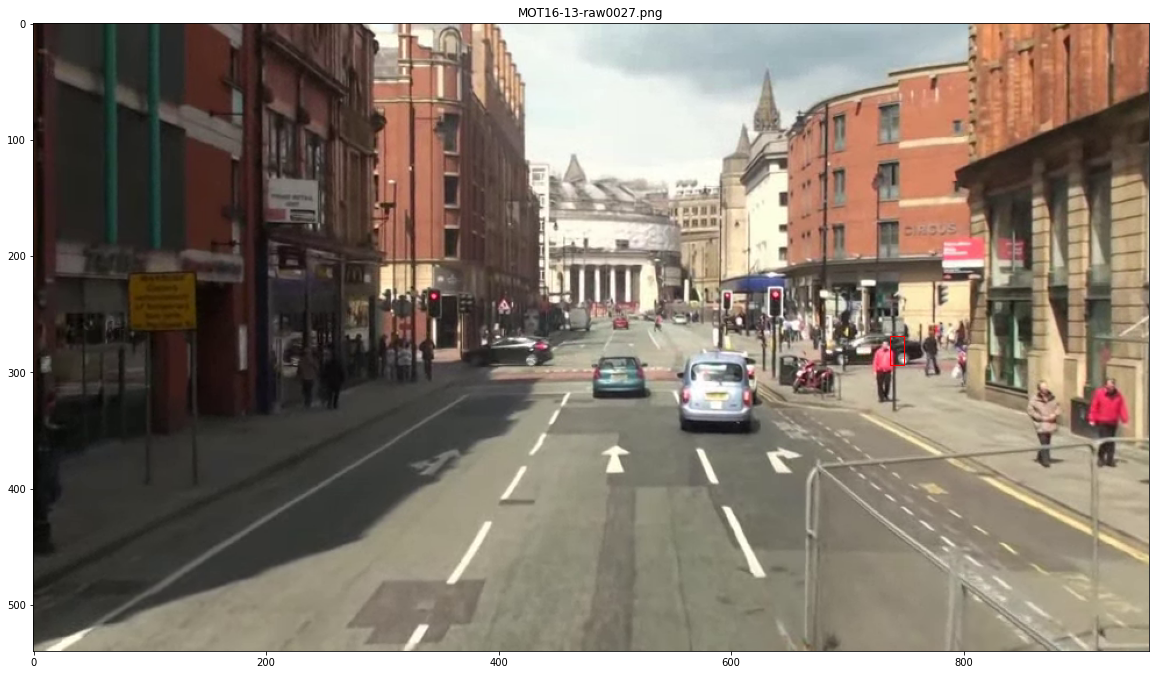

In [128]:
## check matching
i = 26
j = 46 # i = 9
img_name = img_names[i]
img = Image.open(img_path + img_name)

ma_boxes = ma_saved2[j]['boxes']


bboxes = []
for bbox in ma_boxes:
    bbox = list(bbox)
    x0, y0 = bbox[0], bbox[1]
    x1, y1 = bbox[2], bbox[3]

    bboxes.append([x0, y0, x1 - x0, y1 - y0])

plt.rcParams['figure.figsize'] = [20, 12]
fig, ax = plt.subplots()
plt.imshow(img);
plt.title(img_name)

# bbox = [x, y, w, h]
colors = ['red', 'green', 'blue']
k = 0
for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor=colors[k],linestyle ='-', facecolor='none')
    ax.add_patch(rect)  
    k += 1
plt.show()

In [141]:
import os

path = '/home/marko/data/video/bus-video/detected-frames/'
images = os.listdir(path)

images2 = []
for img in images:
    if 'png' in img:
        images2.append(img)
images = images2

images3 = []
for i in range(1, len(images) + 1):
    images3.append('MOT16-13-raw%04d.png' % (i))
    
for i in range(len(images)):
    os.rename(path + images[i], path + images3[i])    

In [18]:
threshold = .7
i = 3
img_name = img_names[i]
img = Image.open(img_path + img_name)

img_name_pub = img_names_pub[i]
img_pub = Image.open(img_path_pub + img_name_pub)

pred = bus_preds[img_name]
highs = list(np.where(pred['scores'] > threshold)[0])
bboxes_x0x1y0y1 = []

for high in highs:
    bboxes_x0x1y0y1.append(list(pred['boxes'][high]))

bboxes = []
for bbox in bboxes_x0x1y0y1:
    bbox = list(bbox)
    x0, y0 = bbox[0], bbox[1]
    x1, y1 = bbox[2], bbox[3]

    bboxes.append([x0, y0, x1 - x0, y1 - y0])

plt.rcParams['figure.figsize'] = [12, 8]

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.gca().set_axis_off()

plt.subplots_adjust(
    left=0.01,         # position of the left edge of the subplots, as a fraction of the figure width
    right=(1 - 0.01),  # position of the right edge of the subplots, as a fraction of the figure width
    bottom=0.01,
    top=(1 - 0.01),
    wspace=0.1
)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

## enumerate frames
plt.gcf().text(0.55, 0.65, str(i+1), fontsize=14, color='black')

text_string = 'Video: MOT Challenge - Pedestrian Detection Challenge, filmed from a bus on a busy intersection at 25fps.'
plt.gcf().text(0.01, 0.18, text_string, fontsize=14)

text_string = 'Public detections: taken from  MOT Challenge public detections (https://motchallenge.net/vis/MOT16-13/det/).'
plt.gcf().text(0.01, 0.14, text_string, fontsize=14)

text_string = 'Our detections: modified Faster R-CNN trained on CityPersons (threshold=0.7) + MA(3) on Tesla V100 at ~6fps.'
plt.gcf().text(0.01, 0.1, text_string, fontsize=14)

ax1.set_axis_off()
ax2.set_axis_off()

ax1.imshow(img_pub)
ax2.imshow(img)

ax1.set_title('Public detections', fontsize=20)
ax2.set_title('Our detections', fontsize=20)

# bbox = [x, y, w, h]
for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='red',linestyle ='-', facecolor='none')
    ax2.add_patch(rect)   

fig.savefig(dest_path + img_name, dpi=300, pad_inches = 0,
            facecolor='white', edgecolor='black')
plt.close()